In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import os
import sys
from functools import reduce
from tensorflow.keras.optimizers import SGD
from sklearn.linear_model import LogisticRegression

import pandas as pd
import pyarrow.parquet as pq
import csv
import glob
from keras import models
from keras import layers
from keras import Input
import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from collections import Counter
from keras.callbacks import History
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
# import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
import keras_tuner as kt
from matplotlib import pyplot
import xlsxwriter
np.set_printoptions(threshold=sys.maxsize)


In [2]:
# ## 1. Jittering

# #### Hyperparameters :  sigma = standard devitation (STD) of the noise
def DA_Jitter(X, sigma=0.01):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + myNoise


# ## 2. Scaling

# #### Hyperparameters :  sigma = STD of the zoom-in/out factor
def DA_Scaling(X, sigma=0.5):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1, X.shape[1]))  # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0], 1)), scalingFactor)
    return X * myNoise


# ## 3. Magnitude Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

# "Scaling" can be considered as "applying constant noise to the entire samples" whereas "Jittering" can be considered as "applying different noise to each sample".

# "Magnitude Warping" can be considered as "applying smoothly-varing noise to the entire samples"


## This example using cubic splice is not the best approach to generate random curves.
## You can use other aprroaches, e.g., Gaussian process regression, Bezier curve, etc.
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1], 1)) * (np.arange(0, X.shape[0], (X.shape[0] - 1) / (knot + 1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot + 2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    random_curves = []
    for i in range(X.shape[-1]):
        cs = CubicSpline(xx[:, i], yy[:, i])
        random_curves.append(cs(x_range))
    return np.array(random_curves).transpose()


def DA_MagWarp(X, sigma=0.2):
    return X * GenerateRandomCurves(X, sigma)


# ## 4. Time Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma)  # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)  # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    for i in range(X.shape[-1]):
        t_scale = (X.shape[0] - 1) / tt_cum[-1, i]
        tt_cum[:, i] = tt_cum[:, i] * t_scale
    return tt_cum


def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    for i in range(X.shape[-1]):
        X_new[:, i] = np.interp(x_range, tt_new[:, i], X[:, i])
    return X_new


# ## 5. Permutation

# #### Hyperparameters :  nPerm = # of segments to permute
# #### minSegLength = allowable minimum length for each segment

def DA_Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile:
        segs = np.zeros(nPerm + 1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0] - minSegLength, nPerm - 1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:] - segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii] + 1], :]
        X_new[pp:pp + len(x_temp), :] = x_temp
        pp += len(x_temp)
    return X_new


In [3]:
def augment_data(train_set, train_label, function):

    train_set_one = train_set
#     START AUGMENTING
    LABEL = []
    # select random indices
    number_of_rows = int(train_set_one.shape[0] * 0.5)

#     random indices has to be the same for every dimension so that the label can be accurate
    random_indices = np.sort(np.random.choice(train_set_one.shape[0]-1, size=int(number_of_rows), replace=False))
    train_set_one = train_set_one[random_indices,:]
    
    
    train_set_one = train_set_one.transpose()
    if function == 'scale':
        train_set_one = DA_Scaling(train_set_one)
    elif function == 'jitter':
        train_set_one = DA_Jitter(train_set_one)
    elif function == 'magWarp':
        train_set_one = DA_MagWarp(train_set_one)
    elif function == 'timeWarp':
        train_set_one = DA_TimeWarp(train_set_one)
    elif function == 'rotation':
        train_set_one = DA_Rotation(train_set_one)
    elif function == 'permutation':
        train_set_one = DA_Permutation(train_set_one)
    else:
        print("Error no augmentation function")
        return -1
    train_set_one = train_set_one.transpose()
        
    
    # take the label and add them as the label for the new augmented data
    LABEL = np.array(train_label[random_indices])
#     we have ARR which is of shape (6, row, col) with the augmented data
#     and train_set which is of shape (6, row, col) with the non augmented data
    
    train_set_augmented = np.concatenate((train_set, train_set_one), axis = 0)
    print(train_set[0,0])
    print(train_set_one[0,0])
    train_label = np.array(train_label)
    label_set_augmented = np.concatenate((train_label, LABEL))
    
    return train_set_augmented, label_set_augmented



In [4]:
def model_network():
    seed_value = 34567892
    os.environ['PYTHONHASHSEED']=str(seed_value)
    tf.random.set_seed(seed_value)

    model = Sequential()
    model.add(Input(shape=(2400,)))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(learning_rate=0.0001,momentum=0.0)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', Recall(), Precision()])
    return model

2022-06-02 10:45:25.847035: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


evaluate original:  [0.684959888458252, 0.5478180050849915, 0.190476194024086, 0.6172839403152466]


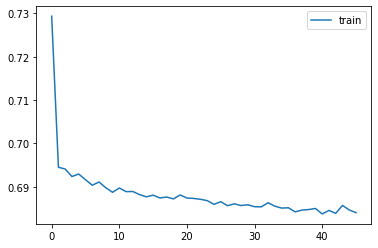

jitter
0.503648
0.519111429758514
evaluate augmented :  jitter [0.6670112013816833, 0.6332404613494873, 0.508571445941925, 0.6608911156654358]


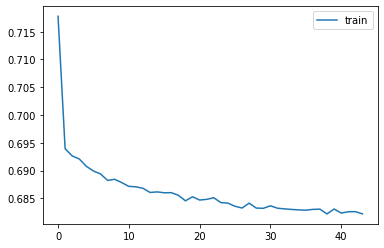

0.503648
0.49842225104704857
evaluate augmented :  jitter [0.6611225008964539, 0.5988857746124268, 0.8780952095985413, 0.5560916662216187]


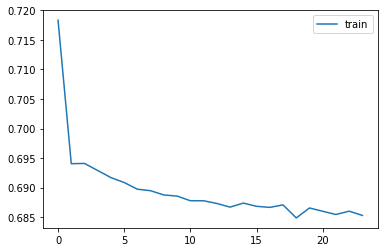

0.503648
0.5224459814868905
evaluate augmented :  jitter [0.6607043147087097, 0.6480965614318848, 0.8438095450401306, 0.5986486673355103]


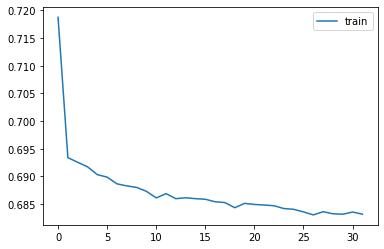

0.503648
0.16433836065220442
evaluate augmented :  jitter [0.6616310477256775, 0.5988857746124268, 0.8857142925262451, 0.5555555820465088]


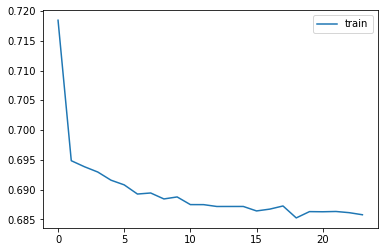

0.503648
0.15677639906014007
evaluate augmented :  jitter [0.6621789336204529, 0.6490250825881958, 0.8095238208770752, 0.6045519113540649]


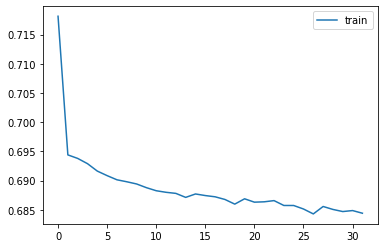

0.503648
0.518514921837603
evaluate augmented :  jitter [0.662747859954834, 0.63138347864151, 0.8628571629524231, 0.5822622179985046]


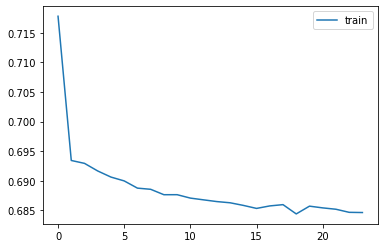

0.503648
0.15091578777738737
evaluate augmented :  jitter [0.6606755256652832, 0.6146703958511353, 0.8742856979370117, 0.5680692791938782]


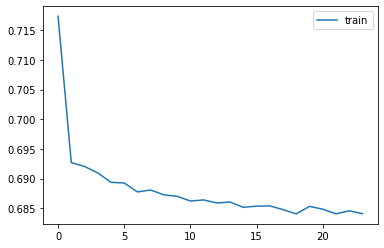

0.503648
0.2525091632231671
evaluate augmented :  jitter [0.6619347929954529, 0.6295264363288879, 0.8514285683631897, 0.58203125]


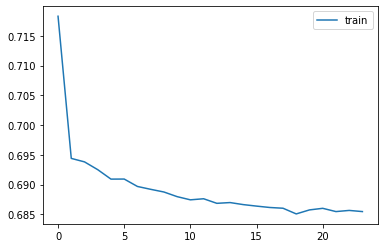

0.503648
0.16013011183175818
evaluate augmented :  jitter [0.6673886179924011, 0.6239554286003113, 0.46857142448425293, 0.6612903475761414]


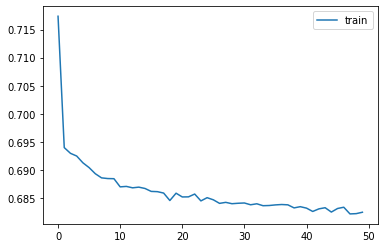

0.503648
0.12618040979842643
evaluate augmented :  jitter [0.6685993075370789, 0.6174558997154236, 0.43238094449043274, 0.6656891703605652]


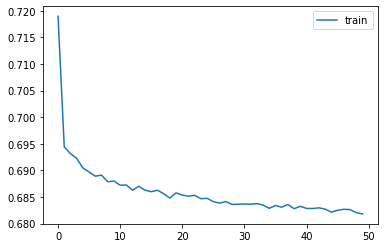

[63.32404613494873, 59.888577461242676, 64.80965614318848, 59.888577461242676, 64.90250825881958, 63.138347864151, 61.467039585113525, 62.952643632888794, 62.39554286003113, 61.74558997154236]
62.45% (+/- 1.66%)
scale
0.503648
0.29999924838433284
evaluate augmented :  scale [0.6662269830703735, 0.6360260248184204, 0.5066666603088379, 0.6666666865348816]


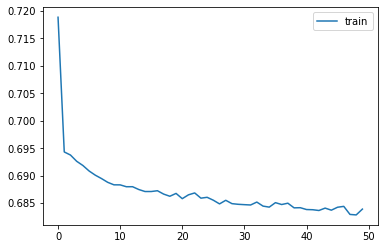

0.503648
0.7116595725457344
evaluate augmented :  scale [0.6626173853874207, 0.6583101153373718, 0.7085714340209961, 0.6337308287620544]


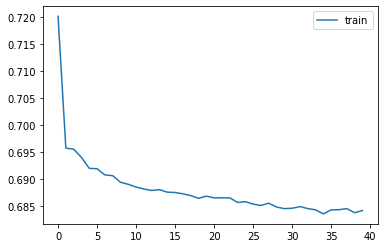

0.503648
0.22039460324643798
evaluate augmented :  scale [0.6634207963943481, 0.6434540152549744, 0.8438095450401306, 0.5946308970451355]


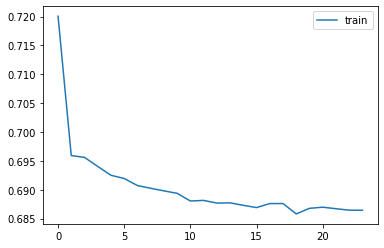

0.503648
0.35156718524771724
evaluate augmented :  scale [0.6620317697525024, 0.6155988574028015, 0.8628571629524231, 0.5698113441467285]


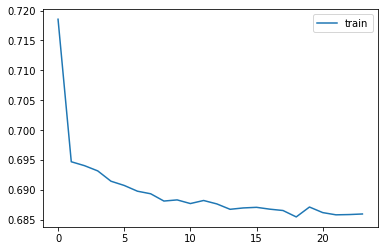

0.503648
-0.02716486677783334
evaluate augmented :  scale [0.6595209836959839, 0.6573815941810608, 0.8209523558616638, 0.6104815602302551]


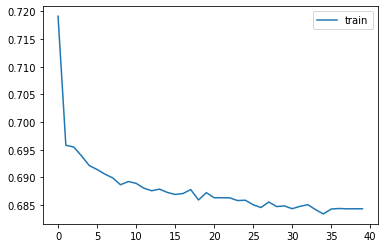

0.503648
0.19917773998193136
evaluate augmented :  scale [0.6597899198532104, 0.6035283207893372, 0.8742856979370117, 0.5597561001777649]


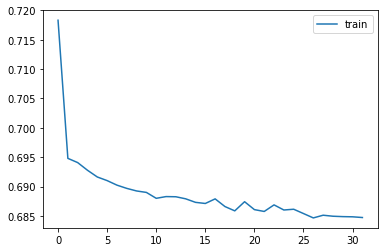

0.503648
0.5878653863964423
evaluate augmented :  scale [0.6602530479431152, 0.6629526615142822, 0.7866666913032532, 0.6219879388809204]


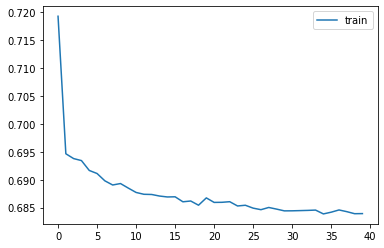

0.503648
0.6277158375759857
evaluate augmented :  scale [0.6613717675209045, 0.6295264363288879, 0.8590475916862488, 0.5811855792999268]


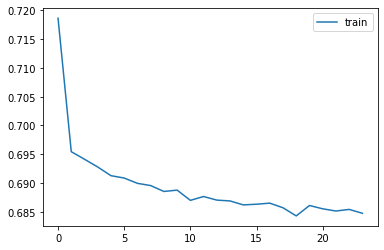

0.503648
0.0931100725087824
evaluate augmented :  scale [0.6628101468086243, 0.6508820652961731, 0.584761917591095, 0.6602150797843933]


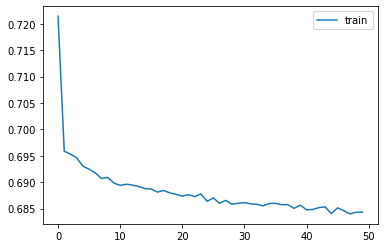

0.503648
0.9557047381264312
evaluate augmented :  scale [0.6638013124465942, 0.6462395787239075, 0.6000000238418579, 0.6481481194496155]


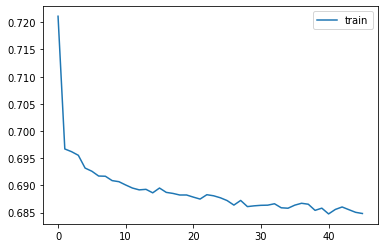

[63.60260248184204, 65.83101153373718, 64.34540152549744, 61.55988574028015, 65.73815941810608, 60.352832078933716, 66.29526615142822, 62.952643632888794, 65.08820652961731, 64.62395787239075]
64.04% (+/- 1.84%)
magWarp
0.503648
0.5099498357476273
evaluate augmented :  magWarp [0.6613670587539673, 0.6425255537033081, 0.8133333325386047, 0.5980392098426819]


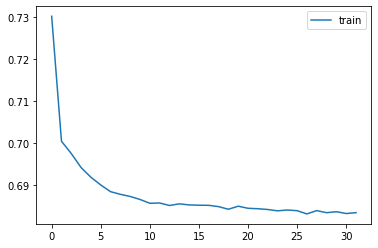

0.503648
0.5412134133901556
evaluate augmented :  magWarp [0.6628009676933289, 0.6137418746948242, 0.8704761862754822, 0.5677018761634827]


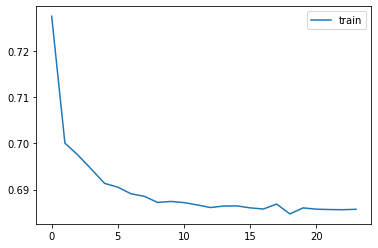

0.503648
0.3077728231205995
evaluate augmented :  magWarp [0.6638995409011841, 0.6137418746948242, 0.8914285898208618, 0.5659008622169495]


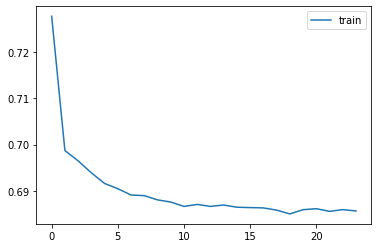

0.503648
0.6013080271871565
evaluate augmented :  magWarp [0.6633816957473755, 0.6137418746948242, 0.8895238041877747, 0.5660606026649475]


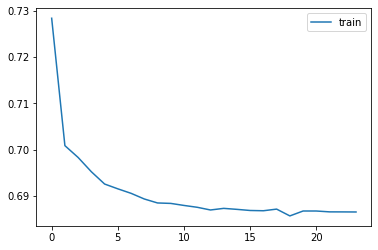

0.503648
0.13105526387560812
evaluate augmented :  magWarp [0.6615913510322571, 0.5942432880401611, 0.8857142925262451, 0.5522565245628357]


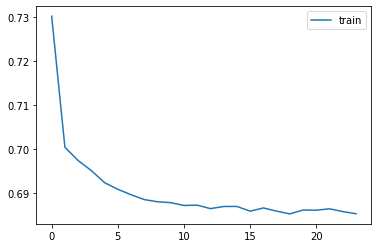

0.503648
0.1460922939617779
evaluate augmented :  magWarp [0.6624787449836731, 0.6555246114730835, 0.7599999904632568, 0.6195651888847351]


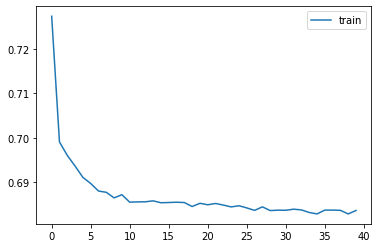

0.503648
0.12064050584222191
evaluate augmented :  magWarp [0.662084698677063, 0.6035283207893372, 0.8799999952316284, 0.5593220591545105]


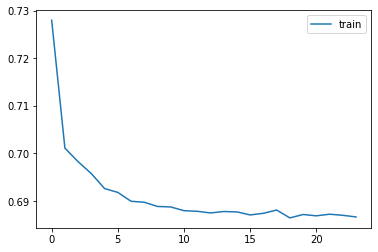

0.503648
0.6046488557208952
evaluate augmented :  magWarp [0.6665624976158142, 0.6443825364112854, 0.7561904788017273, 0.6088957190513611]


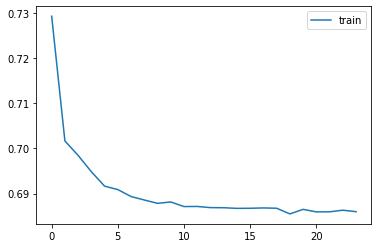

0.503648
0.3999372252817664
evaluate augmented :  magWarp [0.6623402833938599, 0.5961002707481384, 0.8914285898208618, 0.5531914830207825]


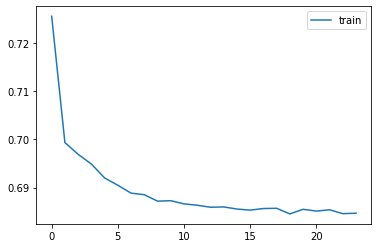

0.503648
0.5311774047715917
evaluate augmented :  magWarp [0.6712356209754944, 0.6155988574028015, 0.4228571355342865, 0.6666666865348816]


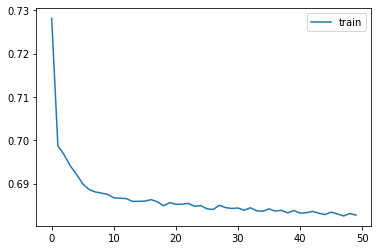

[64.25255537033081, 61.37418746948242, 61.37418746948242, 61.37418746948242, 59.42432880401611, 65.55246114730835, 60.352832078933716, 64.43825364112854, 59.61002707481384, 61.55988574028015]
61.93% (+/- 2.00%)
timeWarp
0.503648
0.503648
evaluate augmented :  timeWarp [0.6656781435012817, 0.6378830075263977, 0.5142857432365417, 0.6666666865348816]


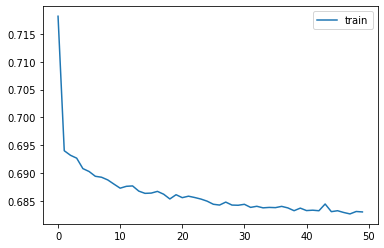

0.503648
0.503648
evaluate augmented :  timeWarp [0.6624621152877808, 0.6174558997154236, 0.8723809719085693, 0.5703611373901367]


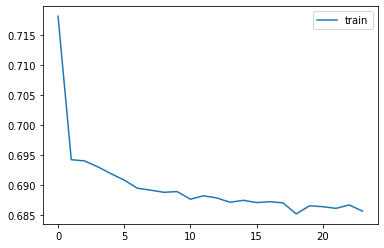

0.503648
0.161656
evaluate augmented :  timeWarp [0.6612326502799988, 0.6471680402755737, 0.7561904788017273, 0.6117103099822998]


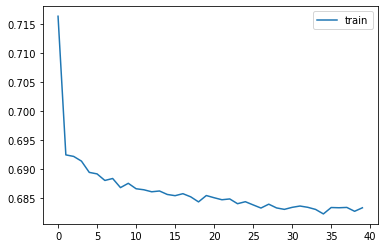

0.503648
0.161656
evaluate augmented :  timeWarp [0.6614838242530823, 0.621169924736023, 0.8647618889808655, 0.5739570260047913]


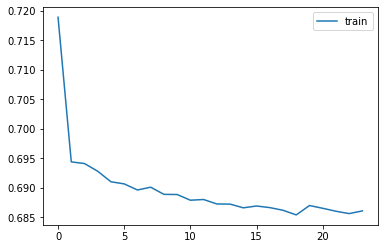

0.503648
0.161656
evaluate augmented :  timeWarp [0.6658172011375427, 0.6369544863700867, 0.5180952548980713, 0.6634146571159363]


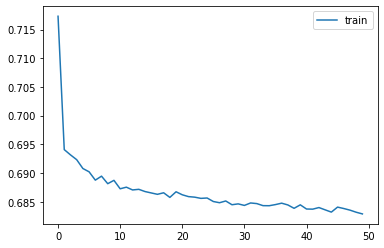

0.503648
0.161656
evaluate augmented :  timeWarp [0.660617470741272, 0.5988857746124268, 0.8742856979370117, 0.5563636422157288]


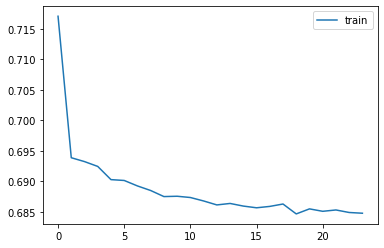

0.503648
0.503648
evaluate augmented :  timeWarp [0.6615299582481384, 0.6063138246536255, 0.868571400642395, 0.5622687935829163]


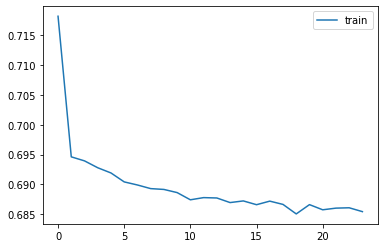

0.503648
0.510121
evaluate augmented :  timeWarp [0.6643321514129639, 0.6573815941810608, 0.6399999856948853, 0.6511628031730652]


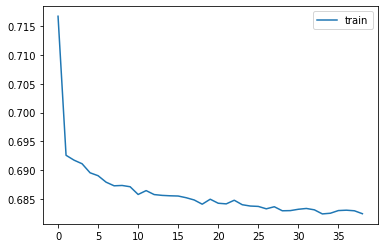

0.503648
0.503648
evaluate augmented :  timeWarp [0.6621240377426147, 0.6276694536209106, 0.8552380800247192, 0.58010333776474]


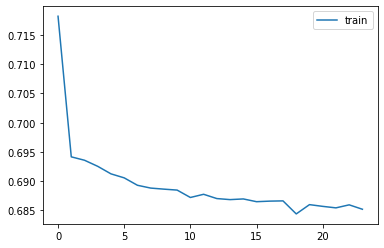

0.503648
0.17676
evaluate augmented :  timeWarp [0.6627243757247925, 0.632311999797821, 0.8533333539962769, 0.5840938687324524]


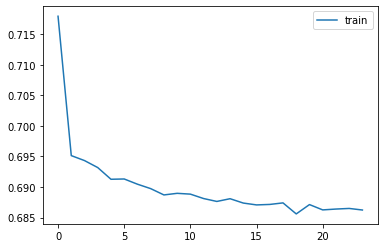

[63.78830075263977, 61.74558997154236, 64.71680402755737, 62.116992473602295, 63.69544863700867, 59.888577461242676, 60.63138246536255, 65.73815941810608, 62.766945362091064, 63.231199979782104]
62.83% (+/- 1.70%)
permutation
0.503648
0.161656
evaluate augmented :  permutation [0.6617565155029297, 0.63138347864151, 0.8571428656578064, 0.5829015374183655]


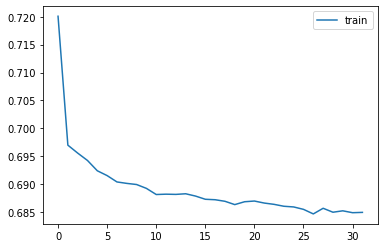

0.503648
0.171903
evaluate augmented :  permutation [0.6614592671394348, 0.6090993285179138, 0.8799999952316284, 0.5634146332740784]


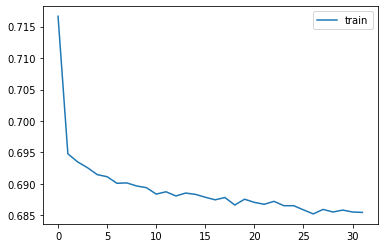

0.503648
0.092489
evaluate augmented :  permutation [0.6715144515037537, 0.6072423458099365, 0.4399999976158142, 0.6416666507720947]


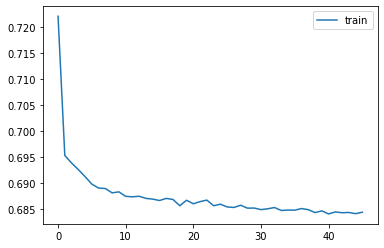

0.503648
0.257721
evaluate augmented :  permutation [0.6700596213340759, 0.6128133535385132, 0.4285714328289032, 0.6578947305679321]


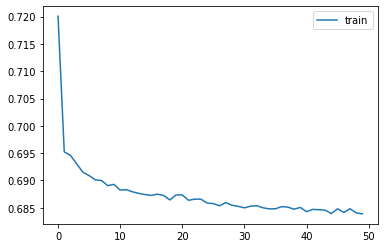

0.503648
0.467784
evaluate augmented :  permutation [0.6606731414794922, 0.6610956192016602, 0.822857141494751, 0.6136363744735718]


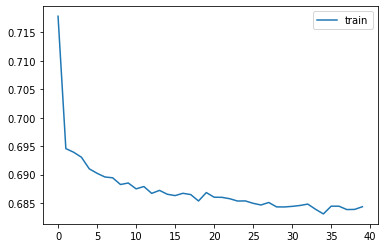

0.503648
0.155252
evaluate augmented :  permutation [0.6624900698661804, 0.5988857746124268, 0.8857142925262451, 0.5555555820465088]


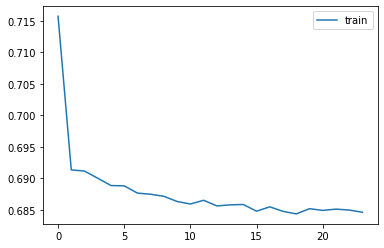

0.503648
0.510121
evaluate augmented :  permutation [0.7121934294700623, 0.524605393409729, 0.04952380806207657, 0.6666666865348816]


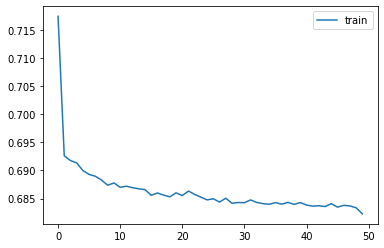

0.503648
0.171903
evaluate augmented :  permutation [0.6630329489707947, 0.6100278496742249, 0.8876190185546875, 0.5634824633598328]


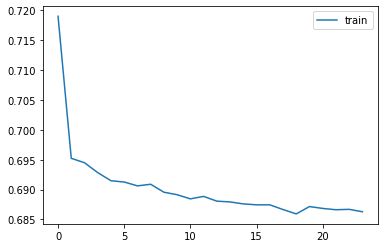

0.503648
0.285634
evaluate augmented :  permutation [0.664005696773529, 0.6471680402755737, 0.7504761815071106, 0.6127527356147766]


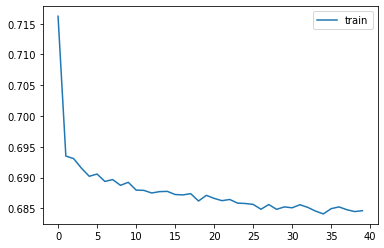

0.503648
0.25644
evaluate augmented :  permutation [0.6655141115188599, 0.6508820652961731, 0.8380952477455139, 0.601915180683136]


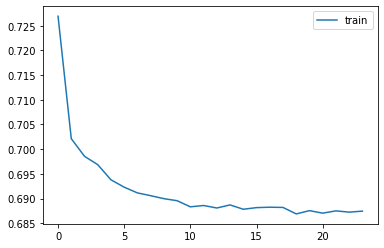

[63.138347864151, 60.90993285179138, 60.72423458099365, 61.28133535385132, 66.10956192016602, 59.888577461242676, 52.4605393409729, 61.002784967422485, 64.71680402755737, 65.08820652961731]
61.53% (+/- 3.64%)


In [5]:
# for each technique run tec_len times the model to obtain an average of accuracy and fill the csv table with results
techniques = ['jitter', 'scale', 'magWarp', 'timeWarp', 'permutation']

arr_eda, arr_bvc,arr_acc,arr_tem = [],[],[],[]
std_arr = []
arr_eda_percentage, arr_bvc_percentage,arr_acc_percentage,arr_tem_percentage = [],[],[],[]
tec_eda, tec_bvc, tec_acc, tec_tem = 0,0,0,0

recall_eda, recall_bvc, recall_acc, recall_tem = [],[],[],[]
precision_eda, precision_bvc, precision_acc, precision_tem = [],[],[],[]

train_set = np.load('train_set_original.npy',  encoding='ASCII')
train_label = np.load('train_label_original.npy',  encoding='ASCII')
test_set = np.load('test_set.npy',  encoding='ASCII')
test_label = np.load('test_label.npy',  encoding='ASCII')
train_label = train_label.reshape(train_label.shape[0], 1)
test_label = test_label.reshape(test_label.shape[0], 1)




# for dim in range(0, 4):
train_set_arr = train_set[0]
test_set_arr = test_set[0]

model = model_network()

# ORIGINAL SET
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(train_set_arr, train_label, epochs=50, batch_size= 128, shuffle=True, verbose=0, callbacks=[callback])
scores1 = model.evaluate(test_set_arr, test_label, verbose=0)
print("evaluate original: ",scores1)
tec_eda = scores1[1]
recall_original = scores1[2]
precision_original = scores1[3]

recall_eda.append(recall_original)
precision_eda.append(precision_original)

pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()
            
# --------------------------------------------------------------------


for technique in techniques:
    print(technique)
    avg_tec_eda = []
    
    recall_original, precision_original, recall_aug, precision_aug = 0,0,0,0
    cvscores = []
    
    tec_len = 10
    
# loop tec_len times to get the average of a tecnique
    for avg_t in range(0, tec_len):
        train_set = np.load('train_set_original.npy',  encoding='ASCII')
        train_label = np.load('train_label_original.npy',  encoding='ASCII')
        test_set = np.load('test_set.npy',  encoding='ASCII')
        test_label = np.load('test_label.npy',  encoding='ASCII')
        train_label = train_label.reshape(train_label.shape[0], 1)
        test_label = test_label.reshape(test_label.shape[0], 1)

        
        train_set_arr_augment, label_set_augmented = augment_data(train_set[0], train_label, technique)
        
        test_set_arr = test_set[0]
        model = model_network()

        # AUGMENTATION
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        history = model.fit(train_set_arr_augment, label_set_augmented, epochs=50, batch_size= 128, shuffle=True,verbose=0, callbacks = [callback])
        scores2 = model.evaluate(test_set_arr, test_label,verbose=0)
        #     --------------------------------------------------------------------
        print("evaluate augmented : ", technique, scores2)

        avg_tec_eda.append(scores2[1])
#         std_arr.append(scores2[1])
        cvscores.append(scores2[1] * 100)
        recall_aug += scores2[2]
        precision_aug += scores2[3]

        pyplot.plot(history.history['loss'], label='train')
        pyplot.legend()
        pyplot.show()
 

    arr_eda.append(np.mean(avg_tec_eda))
    recall_eda.append(recall_aug/tec_len)
    precision_eda.append(precision_aug/tec_len)
    print(cvscores)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    std_arr.append(np.std(cvscores))

    arr_eda_percentage.append(round((np.mean(avg_tec_eda) - tec_eda) * 100, 4))


# insert eda and baseline
arr_eda.insert(0, tec_eda)
# std_arr = [np.std(std_arr)]
std_arr.insert(0, 0)
# recall_eda.insert(0, recall_original)
# precision_eda.insert(0, precision_original)

arr_eda.insert(0, 'EDA')
recall_eda.insert(0, 'RECALL')
precision_eda.insert(0, 'PRECISION')
std_arr.insert(0, 'STD')

# print("STD: ", std)
header = ['sensor', 'baseline', 'jitter', 'scale', 'magWarp', 'timeWarp', 'permutation']

with open('table_accuracy.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerow(arr_eda)
    writer.writerow(recall_eda)
    writer.writerow(precision_eda)
    writer.writerow(std_arr)
    writer.writerow([])
    arr_eda_percentage.insert(0, 0)
    arr_eda_percentage.insert(0, 'EDA')
    writer.writerow(arr_eda_percentage)


